In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from sklearn.model_selection import train_test_split
from torchinfo import summary
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import os

from model.fcae import createLevel6Net_10x10, createLevel7Net_20x20, createLevel8Net_30x30, createLevel8Net_40x40, createLevel8Net_50x50

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# # Train/Test Split
path_to_data = "./data/"

data_size = (50, 50)

X_file = np.load(f"{path_to_data}100000x{data_size[0]}x{data_size[1]}_unsolved.npy")
Y_file = np.load(f"{path_to_data}100000x{data_size[0]}x{data_size[1]}_solved.npy")

X_file = (X_file - X_file.min() ) / ( X_file.max() - X_file.min())

x_tensor = torch.tensor(X_file, dtype=torch.float32, device=device)
y_tensor = torch.tensor(Y_file, dtype=torch.float32, device=device)

dataset = TensorDataset(x_tensor, y_tensor)

total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batchsize = 64
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize)

In [4]:
# 10x10
# net, _, _ = createLevel6Net_10x10()
# net.load_state_dict(
#     torch.load(
#         "./archive/Level6Net_10x10_99.9900/net.pt",
#         weights_only=True,
#     )
# )
# 20x20
# net, _, _ = createLevel7Net_20x20()
# net.load_state_dict(
#     torch.load(
#         "./archive/Level7Net_20x20_99.1000/net.pt",
#         weights_only=True,
#     )
# )
# 30x30
# net, _, _ = createLevel8Net_30x30()
# net.load_state_dict(
#     torch.load(
#         "./archive/Level8Net_30x30_89.8200/net.pt",
#         weights_only=True,
#     )
# )
# 40x40
# net, _, _ = createLevel8Net_40x40()
# net.load_state_dict(
#     torch.load(
#         "./archive/Level8Net_40x40_83.9350/net.pt",
#         weights_only=True,
#     )
# )
# 50x50
net, _, _ = createLevel8Net_50x50()
net.load_state_dict(
    torch.load(
        "./archive/Level8Net_50x50_75.3600/net.pt",
        weights_only=True,
    )
)

<All keys matched successfully>

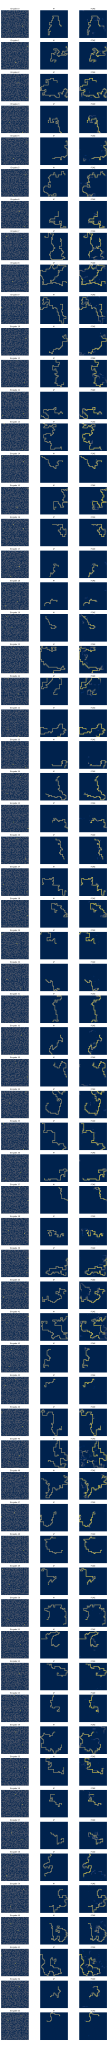

In [5]:
# **Batch abrufen**
X_batch, y_batch = next(iter(test_loader))

# **Model auf das richtige Gerät setzen und in den Evaluierungsmodus**
net.to(device)
net.eval()

# **Vorhersagen berechnen**
y_hat_fcae = net(X_batch.to(device)).squeeze().detach().cpu().numpy()

# **Anzahl der Labyrinthe im Batch**
num_samples = X_batch.shape[0]

# **Plot erstellen (num_samples Zeilen, 3 Spalten)**
fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))

for i in range(num_samples):
    # **Eingabe-Labyrinth**
    axes[i, 0].imshow(X_batch[i, 0].cpu().numpy(), cmap="cividis")
    axes[i, 0].set_title(f"Eingabe {i}", fontsize=12)
    axes[i, 0].axis("off")

    # **Richtige Lösung**
    axes[i, 1].imshow(y_batch[i, 0].cpu().numpy(), cmap="cividis")
    axes[i, 1].set_title("A*", fontsize=12)
    axes[i, 1].axis("off")

    # **Vorhersage von FCAE**
    axes[i, 2].imshow(y_hat_fcae[i], cmap="cividis")
    axes[i, 2].set_title("FCAE", fontsize=12)
    axes[i, 2].axis("off")

# **Layout anpassen und speichern**
plt.tight_layout()
# plt.savefig("./batch_input_astar_fcae.png", bbox_inches="tight", pad_inches=0)
plt.show()


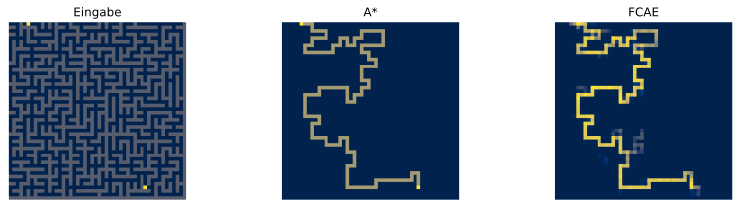

In [7]:
# **Index der anzuzeigenden Reihe**
selected_index = 13  # Hier den gewünschten Index anpassen

# **Sicherstellen, dass der Index gültig ist**
if selected_index >= X_batch.shape[0]:
    raise ValueError(f"Der Index ist zu groß! Maximaler gültiger Index: {X_batch.shape[0]-1}")

# **Daten für die gewählte Reihe auswählen**
X_selected = X_batch[selected_index]
y_selected = y_batch[selected_index]
y_hat_fcae_selected = y_hat_fcae[selected_index]  # Vorhersage von FCAE aus bereits berechneten Daten

# **Plot erstellen (1 Zeile, 3 Spalten)**
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# **Eingabe-Labyrinth**
axes[0].imshow(X_selected[0].cpu().numpy(), cmap="cividis")
axes[0].set_title(f"Eingabe", fontsize=12)
axes[0].axis("off")

# **Richtige Lösung (A*)**
axes[1].imshow(y_selected[0].cpu().numpy(), cmap="cividis")
axes[1].set_title("A*", fontsize=12)
axes[1].axis("off")

# **Vorhersage von FCAE**
axes[2].imshow(y_hat_fcae_selected, cmap="cividis")
axes[2].set_title("FCAE", fontsize=12)
axes[2].axis("off")

# **Layout anpassen und speichern**
plt.tight_layout()
plt.savefig(f"./batch_input_astar_fcae_{data_size[0]}x{data_size[1]}.png", bbox_inches="tight", pad_inches=0)
plt.show()
